# N-Body System
In this notebook, we will go through implementing the inverted pendulum system for which we'll train a neural network to learn to control the pendulum state.

We will train a separate network to learn the system dynamics as well. 

A part of this exercise will also show you how to make animations in matplotlib!

In [1]:
import typing
import warnings

import math
import torch
import einops
import neuralode

warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', UserWarning)

In [2]:
# For convenience, we define the default tensor device and dtype here
torch.set_default_device('cuda')
# In neural networks, we prefer 32-bit/16-bit floats, but for precise integration, 64-bit is preferred. We will revisit this later when we need to mix integration with neural network training
torch.set_default_dtype(torch.float32)

In [3]:
# Henon units
gravitational_constant = torch.tensor(1.0)

def gravitational_force(state, time, masses):
    # state is a N by 6 tensor storing the state of N bodies (3-position, 3-velocity)
    
    p,q = state[...,:3], state[...,3:]
    center_of_mass = (p * masses[...,None]).sum(dim=-2) / masses.sum(dim=-1)
    rel_p = p - center_of_mass[...,None,:]
    
    # we do an outer subtraction of the positions of each body
    diff = rel_p[None] - rel_p[:, None]
    r3 = torch.sum(torch.square(diff), dim=-1)**1.5
    # N by N tensor of distances between the bodies
    # We ignore the diagonals and sum over the rows to get force
    off_diagonal_mask = torch.eye(r3.shape[0], dtype=r3.dtype, device=r3.device) != 1.0
    inv_r3 = torch.where(off_diagonal_mask, 1.0/r3, 0.0)
    
    gravitational_force = -torch.sum(gravitational_constant * diff * masses[:,None,None] * inv_r3[...,None], dim=0)
    
    return torch.cat([q, gravitational_force], dim=-1)

In [4]:
initial_state = torch.tensor([
    [1.1, 0.0, 0.0, 0.0, 0.95, 0.0],
    [-0.9, 0.0, 0.0, 0.0, -1.05, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    ])

masses = torch.tensor([1.0, 1.0, 5.0])
masses = masses / masses.sum()

initial_time = torch.tensor(0.0)
final_time   = torch.tensor(25.0)

initial_timestep = torch.tensor(1e-2)

current_integrator = neuralode.integrators.AdaptiveRK45Integrator

atol, rtol = torch.tensor(0.0), torch.tensor(1e-3)

In [5]:
final_state, _, nbody_states, nbody_times, _ = current_integrator.apply(gravitational_force, initial_state, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, masses)

In [6]:
import matplotlib.pyplot as plt

(<Figure size 1200x1200 with 1 Axes>, <Axes3D: >)

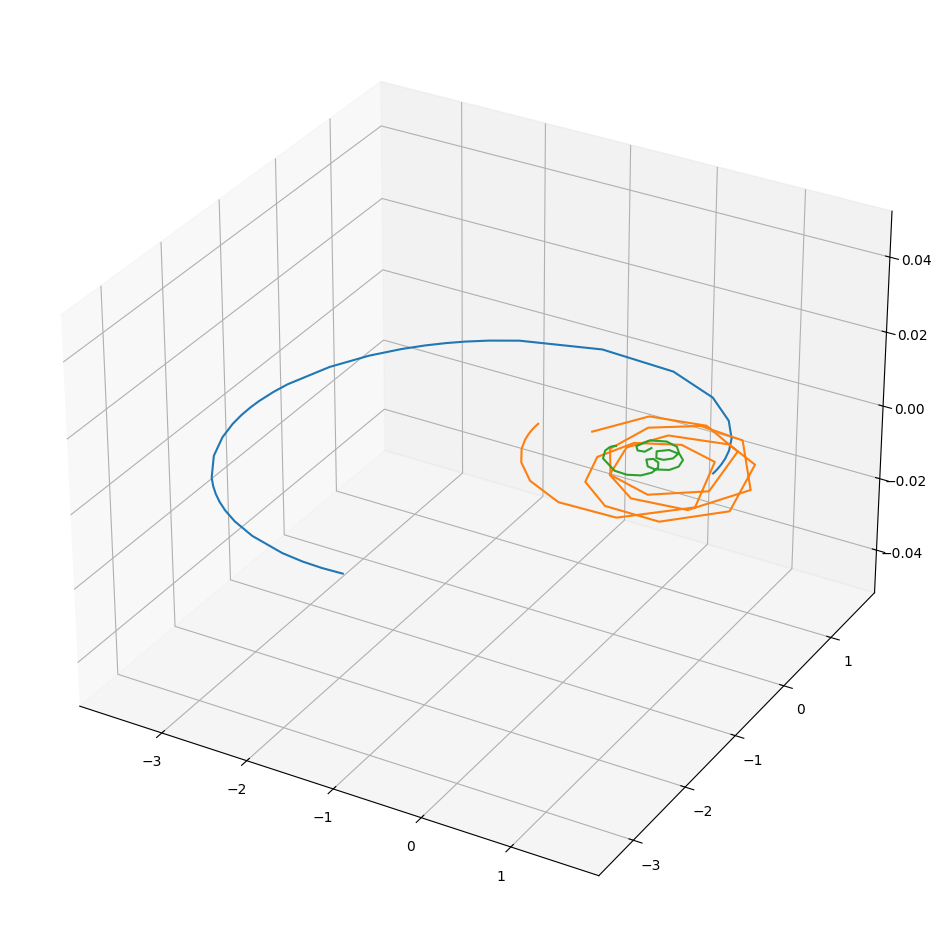

In [7]:
neuralode.plot.trajectory.plot_nbody(nbody_states)

In [8]:
_, _, nbody_ref_states, nbody_ref_times, _ = current_integrator.apply(gravitational_force, initial_state, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol*1e-3}, masses)

(<Figure size 1200x1200 with 1 Axes>, <Axes3D: >)

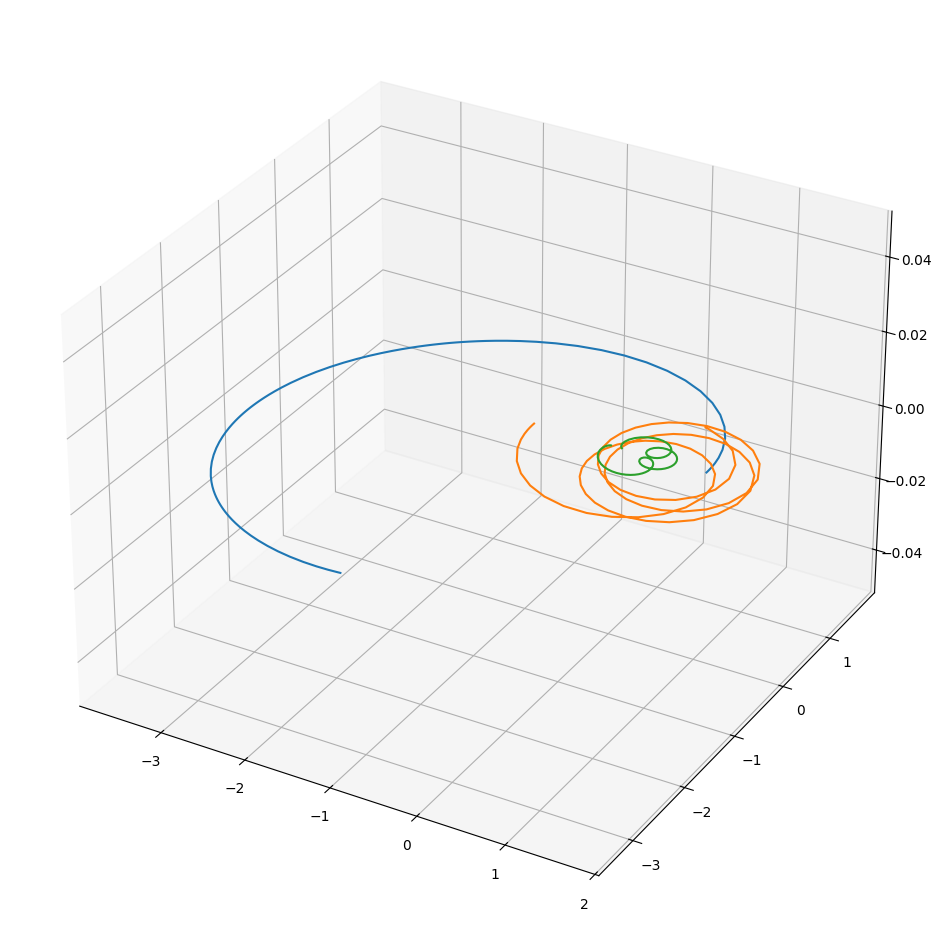

In [9]:
neuralode.plot.trajectory.plot_nbody(nbody_ref_states)

In [10]:
# we define our network as a subclass of torch.nn.Module
# This allows PyTorch to appropriately track parameters
class GravitationalNBodyNet(torch.nn.Module):
    def __init__(self):
        # First we initialise the superclass, `torch.nn.Module`
        super().__init__()
        # Then we define the actual neural network
        # Most Neural Networks operate sequentially so they can be wrapped
        # inside a torch.nn.Sequential which takes each layer
        # as an argument.
        # Since we're only learning one matrix, we have
        # one layer, the `torch.nn.Linear`.
        # `torch.nn.Linear` stores a matrix and a bias which actually makes it
        # an Affine transformation rather than a purely linear transformation
        self.internal_net = torch.nn.Sequential(
            torch.nn.Linear(14, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 7),
        )
    
    def forward(self, pq1, pq2, m1, m2, t):
        x = torch.cat([pq1, pq2, m1[...,None], m2[...,None]], dim=-1)
        if x.dim() == 1:
            force_dir_and_magnitude = self.internal_net(x[None])[0]
        else:
            force_dir_and_magnitude = self.internal_net(x)
        velocity = force_dir_and_magnitude[...,:3]
        force = force_dir_and_magnitude[...,3:6]
        magnitude = force_dir_and_magnitude[...,6]
        return torch.cat([velocity, magnitude[...,None] * force / torch.sqrt(torch.sum(torch.square(force), dim=-1))[...,None]], dim=-1)
        
nbody_net = GravitationalNBodyNet()
# And then instantiate the weights of the network itself
def init_weights(m):
    # For each layer type, we can define how we initialise its values
    if isinstance(m, torch.nn.Linear):
        # A linear equation with a positive coefficient
        # translates to exponential growth and a negative coefficient
        # to exponential decay. In order to preserve stability we sample a matrix
        # that is biased to be negative in its entries thus ensuring
        # that our initial system is of exponential decay.
        torch.nn.init.xavier_normal_(m.weight, gain=0.25)
        if m.bias is not None:
            torch.nn.init.normal_(m.bias)

nbody_net.apply(init_weights)

unknown_mass_fractions = torch.tensor([1.0, 1.0, 1.0], requires_grad=True)

def nbody_dynamics(state, time, masses, *args):
    return torch.stack([
        neuralode.util.compensated_sum(nbody_net(
            state[..., first_mass_idx, :], 
            state[..., second_mass_idx, :], 
            masses[..., first_mass_idx], 
            masses[..., second_mass_idx], 
            time
            ) for second_mass_idx in range(state.shape[-2])) for first_mass_idx in range(state.shape[-2])], dim=-2)

In [11]:
state_dataset = nbody_ref_states[1:].clone()
times_dataset = nbody_ref_times[1:].clone()

# First, we'll create an `optimiser` following pytorch convention
optimiser = torch.optim.Adam([*nbody_net.parameters(), unknown_mass_fractions], lr=1e-2, amsgrad=True)
# # Whenever the loss plateaus, we can reduce the learning rate to improve convergence
lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser)

def nbody_closure(minibatch):
    current_state = initial_state.detach().clone()
    current_time  = initial_time.detach().clone()
    optimiser.zero_grad()
    
    states = minibatch['states']
    times = minibatch['times']
    
    # We need to sort both times and states simultaneously, so we'll use `argsort`
    sorted_time_indices = torch.argsort(times)
    times, states = times[sorted_time_indices], states[sorted_time_indices]
    
    error = 0.0
    
    for sample_state, sample_time in zip(states, times):
        dt = torch.minimum(initial_timestep, sample_time - current_time).detach()
        new_state, new_time, _, _, _ = current_integrator.apply(nbody_dynamics, current_state, current_time, sample_time, dt, {'atol': atol, 'rtol': rtol, 'min_dt': torch.tensor(1e-2)}, unknown_mass_fractions, *nbody_net.parameters())
        error = error + torch.linalg.norm(sample_state - new_state)/times.shape[0]
        current_state, current_time = new_state, new_time
    if error.requires_grad:
        error.backward()
        
    return error

# We need to set the size of our mini-batches
batch_size = 16

# Now we need an optimisation `loop` where we will take steps to minimise the error
number_of_gd_steps = 256

In [ ]:
best_error = torch.inf
best_params = nbody_net.state_dict()

nbody_net.train()

for step in range(number_of_gd_steps):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(state_dataset.shape[0])
    for batch_idx in range(0, state_dataset.shape[0], batch_size):
        batch_dict = {
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
            'times': times_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
    
        step_error = optimiser.step(lambda: nbody_closure(batch_dict))
        epoch_error = epoch_error + step_error.item()*batch_dict['states'].shape[0]
        print(f"[{step+1}/{number_of_gd_steps}]/[{batch_idx}/{state_dataset.shape[0]}] Batch Error: {step_error:.6f}", end='\r')
    epoch_error = epoch_error/state_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_params = nbody_net.state_dict()
    lr_on_plateau.step(epoch_error)
    print(" "*128, end="\r")
    print(f"[{step+1}/{number_of_gd_steps}] Epoch Error: {epoch_error:.6f}")
    # If the step size is too small, then we can interrupt the
    # training as it will not lead to significant improvements
    if lr_on_plateau.get_last_lr()[0] < 1e-6:
        break

In [ ]:
nbody_net.load_state_dict(best_params)
nbody_net.eval()

with torch.no_grad():
    final_state_nn, _, nbody_states_nn, nbody_times_nn, _ = current_integrator.apply(nbody_dynamics, initial_state, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, unknown_mass_fractions)

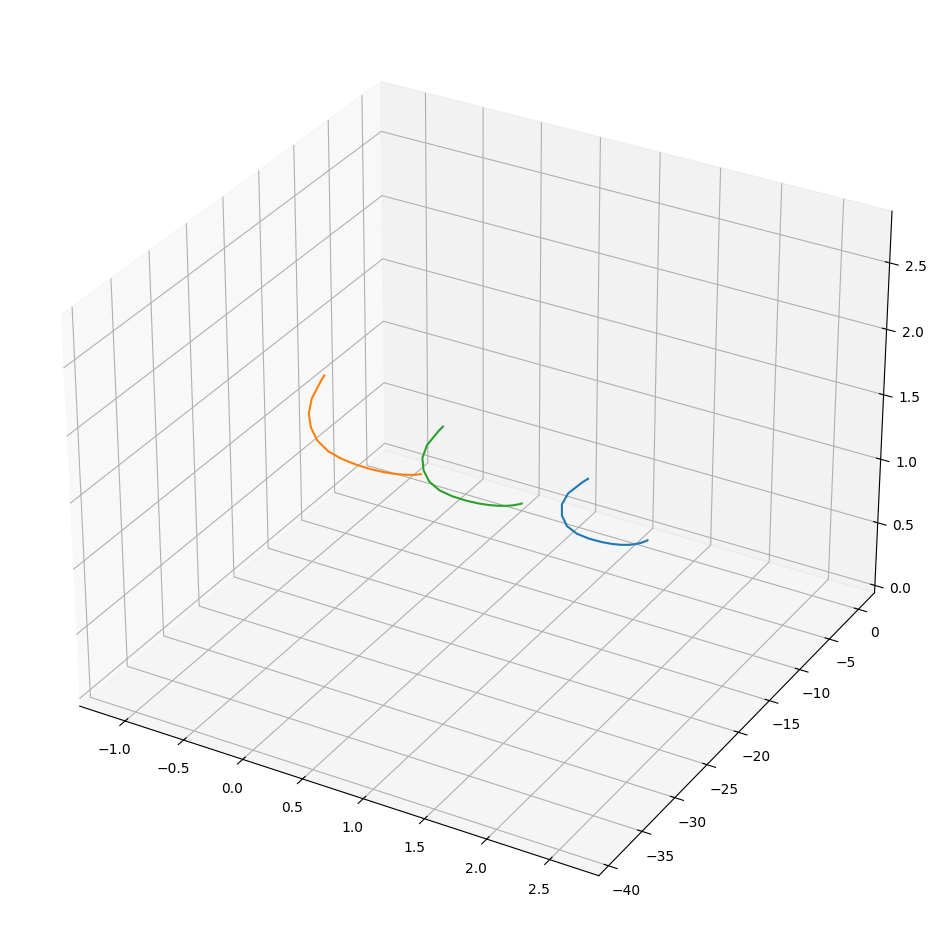

In [18]:
m1_xyz = nbody_states_nn[...,0,:3]
m2_xyz = nbody_states_nn[...,1,:3]
m3_xyz = nbody_states_nn[...,2,:3]

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*m1_xyz.permute(1,0).cpu().numpy())
ax.plot(*m2_xyz.permute(1,0).cpu().numpy())
ax.plot(*m3_xyz.permute(1,0).cpu().numpy())

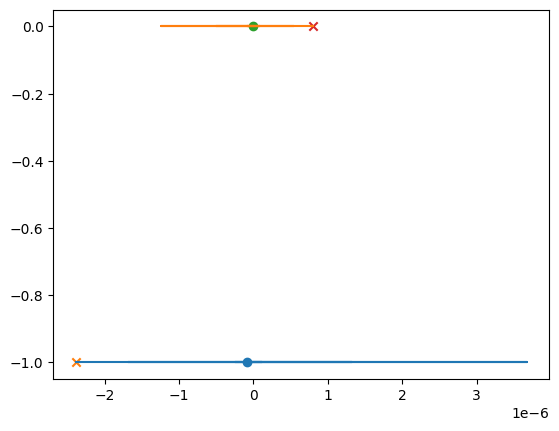

In [7]:
pendulum_x = torch.sin(sha_states[...,0]) * length_pole + sha_states[...,2]
pendulum_y = torch.cos(sha_states[...,0]) * length_pole

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pendulum_x[0].item(), pendulum_y[0].item(), marker='o')
ax.scatter(pendulum_x[-1].item(), pendulum_y[-1].item(), marker='x')
ax.plot(pendulum_x.cpu().numpy(), pendulum_y.cpu().numpy())
ax.plot(sha_states[...,2].cpu().numpy(), torch.zeros_like(sha_states[...,2]).cpu().numpy())
ax.scatter(sha_states[...,2][0].item(), 0.0, marker='o')
ax.scatter(sha_states[...,2][-1].item(), 0.0, marker='x')

In [89]:
# we define our network as a subclass of torch.nn.Module
# This allows PyTorch to appropriately track parameters
class CartPoleNet(torch.nn.Module):
    def __init__(self):
        # First we initialise the superclass, `torch.nn.Module`
        super().__init__()
        # Then we define the actual neural network
        # Most Neural Networks operate sequentially so they can be wrapped
        # inside a torch.nn.Sequential which takes each layer
        # as an argument.
        # Since we're only learning one matrix, we have
        # one layer, the `torch.nn.Linear`.
        # `torch.nn.Linear` stores a matrix and a bias which actually makes it
        # an Affine transformation rather than a purely linear transformation
        self.internal_net = torch.nn.Sequential(
            torch.nn.Linear(5, 8),
            # torch.nn.PReLU(),
            # torch.nn.Linear(8, 8),
            torch.nn.Tanh(),
            torch.nn.Linear(8, 1),
            torch.nn.Tanh(),
        )
    
    def forward(self, x, t):
        # Our network only depends on x, but since it could also depend on t, we have
        # included it for completeness
        # Additionally, PyTorch layers and modules expect a batched tensor
        # ie. a tensor where the first dimension is over different samples
        # Since we don't depend on batches, we check if the input is 1-dimensional
        # And add a batch dimension as needed for the internal module
        encoded_state = torch.stack(
            [torch.cos(x[...,0]), torch.sin(x[...,0]), x[...,1], x[...,2], x[...,3]],
        dim=-1)
        if x.dim() == 1:
            return self.internal_net(encoded_state[None])[0]
        else:
            return self.internal_net(encoded_state)
        
nbody_net = CartPoleNet()
# And then instantiate the weights of the network itself
def init_weights(m):
    # For each layer type, we can define how we initialise its values
    if isinstance(m, torch.nn.Linear):
        # A linear equation with a positive coefficient
        # translates to exponential growth and a negative coefficient
        # to exponential decay. In order to preserve stability we sample a matrix
        # that is biased to be negative in its entries thus ensuring
        # that our initial system is of exponential decay.
        torch.nn.init.xavier_normal_(m.weight, gain=1.0)
        if m.bias is not None:
            torch.nn.init.normal_(m.bias)

nbody_net.apply(init_weights)
max_force = torch.tensor(60.0)

def nn_controlled_pendulum(state, time, mc, mp, l, g, mu_c, mu_p, *args):
    encoded_state = torch.stack(
        [torch.cos(state[0]), torch.sin(state[0]), state[1], state[2], state[3]],
    dim=-1)
    force = nbody_net(encoded_state, time).squeeze()
    force = force.clamp(max=max_force) + (force - force.detach())
    return inverted_pendulum(state, time, force, mc, mp, l, g, mu_c, mu_p)

inverted_pendulum_batched = torch.vmap(inverted_pendulum, in_dims=(0, None, 0, None, None, None, None, None, None))

def nn_controlled_pendulum_batched(state, time, mc, mp, l, g, mu_c, mu_p, *args):
    force = nbody_net(state, time)[...,0]
    force = force.clamp(max=max_force) + (force - force.detach())
    return inverted_pendulum_batched(state, time, force, mc, mp, l, g, mu_c, mu_p)

In [95]:
# initial_state_min = torch.tensor([-torch.pi, -torch.pi/final_time, -1.0, -1.0/final_time])
# initial_state_max = torch.tensor([ torch.pi,  torch.pi/final_time,  1.0,  1.0/final_time])
# state_dataset = torch.randn(8, 4) * (initial_state_max - initial_state_min)[None] + initial_state_min[None] # Generate 512 random initial states from which to start the system

state_dataset = initial_state[None].detach().clone()

# def specialised_integrator(x0, t1):
#     return current_integrator.apply(nn_controlled_pendulum, x0, initial_time.detach(), t1, initial_timestep.detach(), {'atol': atol, 'rtol': rtol, 'max_dt': torch.tensor(0.1)}, mass_cart, mass_pole, length_pole, gravity, friction_cart, friction_pole, *cart_pole_net.parameters())[:2]

def batched_integrator(x0):
    return current_integrator.apply(nn_controlled_pendulum_batched, x0, initial_time.detach(), final_time.detach() + 2.5, initial_timestep.detach(), {'atol': atol, 'rtol': rtol}, mass_cart, mass_pole, length_pole, gravity, friction_cart, friction_pole, *nbody_net.parameters())

# First, we'll create an `optimiser` following pytorch convention
optimiser = torch.optim.AdamW(nbody_net.parameters(), lr=5e-2, amsgrad=True)
# # Whenever the loss plateaus, we can reduce the learning rate to improve convergence
lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience = 16)

def pendulum_closure(minibatch):
    optimiser.zero_grad()
    
    states = minibatch['states']
    
    final_state, final_time, intermediate_states, intermediate_times, _ = batched_integrator(states)

    error = torch.linalg.norm(final_state[...,:2], dim=-1).mean() #+ (torch.linalg.norm(intermediate_states[1:-1, ..., :2], dim=-1) * intermediate_times[1:-1].square()).mean()
    # if torch.any(final_state[...,2].abs() > 2.5):
    #     error = error + 1e-3*torch.square(final_state[...,2][final_state[...,2].abs() > 2.5]).mean()
    # if torch.any(intermediate_states[1:-1,...,2].abs() > 2.5):
    #     error = error + 1e-3*torch.square(intermediate_states[1:-1,...,2][intermediate_states[1:-1,...,2].abs() > 2.5]).mean()
    
    if error.requires_grad:
        error.backward()
    # print(error, final_state, final_state[...,0].mean(), torch.linalg.norm(final_state[...,:2], dim=-1))
    return error

# We need to set the size of our mini-batches
batch_size = 8

# Now we need an optimisation `loop` where we will take steps to minimise the error
number_of_gd_steps = 256

In [ ]:
best_error = torch.inf
best_params = nbody_net.state_dict()

nbody_net.train()

for step in range(number_of_gd_steps):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(state_dataset.shape[0])
    for batch_idx in range(0, state_dataset.shape[0], batch_size):
        batch_dict = {
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
    
        step_error = optimiser.step(lambda: pendulum_closure(batch_dict))
        epoch_error = epoch_error + step_error.item()*batch_dict['states'].shape[0]
        print(f"[{step+1}/{number_of_gd_steps}]/[{batch_idx}/{state_dataset.shape[0]}] Batch Error: {step_error:.6f}", end='\r')
    epoch_error = epoch_error/state_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_params = nbody_net.state_dict()
    lr_on_plateau.step(epoch_error)
    print(" "*128, end="\r")
    print(f"[{step+1}/{number_of_gd_steps}] Epoch Error: {epoch_error:.6f}")
    # If the step size is too small, then we can interrupt the
    # training as it will not lead to significant improvements
    if lr_on_plateau.get_last_lr()[0] < 1e-6:
        break

[1/256] Epoch Error: 3.189578                                                                                                   
[2/256] Epoch Error: 3.189507                                                                                                   
[3/256] Epoch Error: 3.189361                                                                                                   
[4/256] Epoch Error: 3.189040                                                                                                   


In [94]:
nbody_net.load_state_dict(best_params)
nbody_net.eval()

final_state, _, sha_states, sha_times, _ = current_integrator.apply(nn_controlled_pendulum, initial_state, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, mass_cart, mass_pole, length_pole, gravity, friction_cart, friction_pole)

nbody_net(sha_states, sha_times)

tensor([[0.9917],
        [0.9917],
        [0.9917],
        [0.9916],
        [0.9916],
        [0.9918],
        [0.9922],
        [0.9929],
        [0.9937],
        [0.9943],
        [0.9946],
        [0.9949],
        [0.9951],
        [0.9953],
        [0.9955],
        [0.9958],
        [0.9961],
        [0.9963],
        [0.9966],
        [0.9970],
        [0.9973],
        [0.9976],
        [0.9979],
        [0.9981],
        [0.9983],
        [0.9984],
        [0.9985],
        [0.9986],
        [0.9987],
        [0.9988],
        [0.9989],
        [0.9990],
        [0.9990],
        [0.9991],
        [0.9991],
        [0.9991],
        [0.9992],
        [0.9992],
        [0.9992],
        [0.9992],
        [0.9992],
        [0.9992],
        [0.9992],
        [0.9992],
        [0.9992],
        [0.9992],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993],
        [0.9993]], device='c

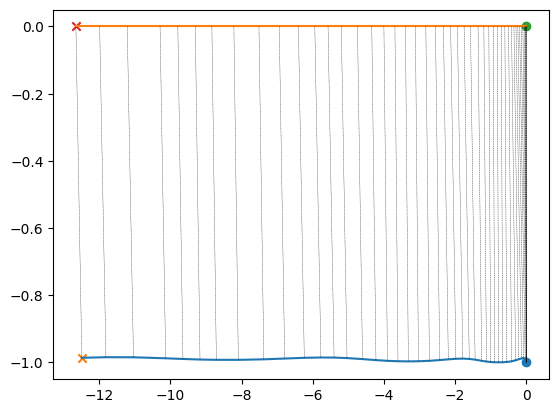

In [86]:
cart_x = sha_states[...,2]
cart_y = torch.zeros_like(cart_x)

pendulum_x = torch.sin(sha_states[...,0]) * length_pole + cart_x
pendulum_y = torch.cos(sha_states[...,0]) * length_pole

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pendulum_x.cpu().numpy(), pendulum_y.cpu().numpy())
ax.plot(cart_x.cpu().numpy(), cart_y.cpu().numpy())

for cx, cy, wx, wy in zip(cart_x, cart_y, pendulum_x, pendulum_y):
    ax.plot([cx.item(), wx.item()], [cy.item(), wy.item()], linewidth=0.25, linestyle='--', color='k')

ax.scatter(pendulum_x[0].item(), pendulum_y[0].item(), marker='o')
ax.scatter(pendulum_x[-1].item(), pendulum_y[-1].item(), marker='x')
ax.scatter(cart_x[0].item(), cart_y[0].item(), marker='o')
ax.scatter(cart_x[-1].item(), cart_y[-1].item(), marker='x')

In [4]:
initial_position = torch.tensor(1.0)
initial_velocity = torch.tensor(0.0)

frequency = (torch.ones_like(initial_position)).requires_grad_(True)
damping = (torch.ones_like(initial_position)*0.25).requires_grad_(True)
initial_state = torch.stack([
    initial_position,
    initial_velocity,
], dim=-1).requires_grad_(True)

initial_time = torch.tensor(0.0).requires_grad_(True)
final_time   = torch.tensor(25.0).requires_grad_(True)

initial_timestep = (final_time - initial_time) / 100

current_integrator = neuralode.integrators.AdaptiveRK87Integrator

atol = rtol = torch.tensor(5e-6)

In [8]:
final_state, _, sha_states, sha_times, _ = current_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, initial_state, initial_time, final_time, initial_timestep, atol, rtol, frequency, damping)

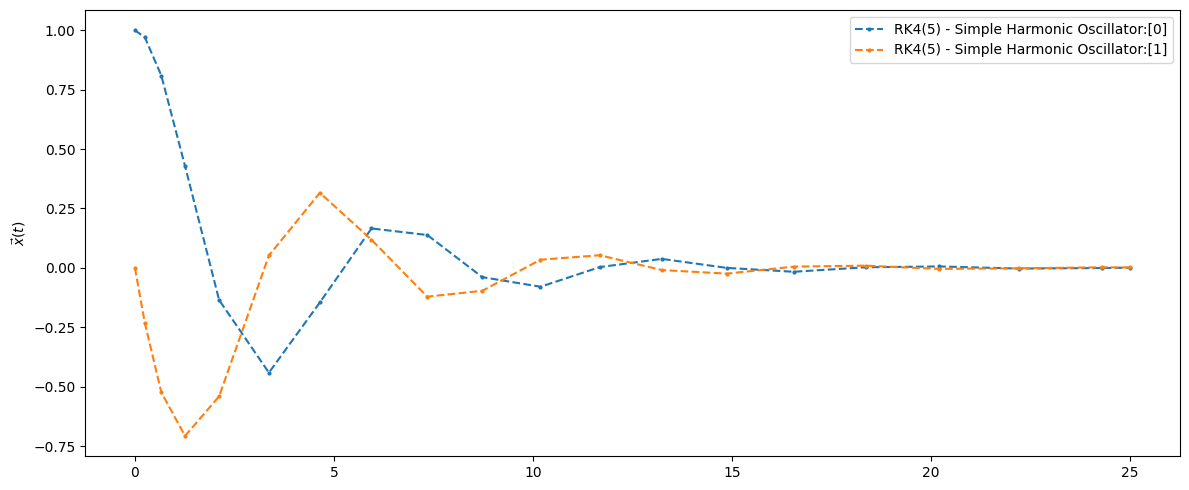

In [7]:
fig, axes = neuralode.plot.trajectory.plot_trajectory([(i, j) for i, j in zip(sha_states, sha_times)], method_label="RK4(5) - Simple Harmonic Oscillator")

In [8]:
# Generate reference trajectory for optimisation/learning
with torch.no_grad():
    _, _, sha_states_ref, sha_times_ref, _ = current_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, initial_state, initial_time, final_time, initial_timestep, atol, rtol, frequency, damping)
sha_states_ref, sha_times_ref = sha_states_ref.detach(), sha_times_ref.detach()

In [9]:
state_dataset = sha_states_ref.clone()
time_dataset  = sha_times_ref.clone()
# We skip the first time as we know the initial state

# We reinitialise our variables
optimised_frequency = torch.tensor(0.1, requires_grad=True)
optimised_damping = torch.tensor(1.0, requires_grad=True)
# As damping needs to be a strictly positive quantity, we log-encode it
log_encoded_damping = torch.log(optimised_damping.detach()).requires_grad_(True)

# First, we'll create an `optimiser` following pytorch convention
optimiser = torch.optim.Adam([optimised_frequency, log_encoded_damping], lr=1e-1, amsgrad=True)
# Whenever the loss plateaus, we can reduce the learning rate to improve convergence
lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser)

# Next, we'll define a closure function whose sole purpose is to
# zero the gradients and compute the error. This is useful as it allows switching to other
# optimisers such as LBFGS or anything that re-evaluates the error without
# computing its gradient
def sha_closure(minibatch):
    current_state = initial_state.detach().clone()
    current_time  = initial_time.detach().clone()
    optimiser.zero_grad()
    error = 0.0
    
    times = minibatch['times']
    states = minibatch['states']
    
    # We need to sort both times and states simultaneously, so we'll use `argsort`
    sorted_time_indices = torch.argsort(times)
    times, states = times[sorted_time_indices], states[sorted_time_indices]
    
    for sample_state, sample_time in zip(states, times):
        dt = torch.minimum(initial_timestep, sample_time - current_time).detach()
        new_state, new_time, _, _, _ = current_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, current_state, current_time, sample_time, dt, atol, rtol, optimised_frequency, torch.exp(log_encoded_damping))
        error = error + torch.linalg.norm(sample_state - new_state)/times.shape[0]
        current_state, current_time = new_state, new_time
    if error.requires_grad:
        error.backward()
    return error

# We need to set the size of our mini-batches
batch_size = 16

# Now we need an optimisation `loop` where we will take steps to minimise the error
number_of_gd_steps = 256*batch_size//time_dataset.shape[0]

# We also need to track the best solution thus far
best_error = torch.inf
best_frequency, best_damping = optimised_frequency.detach().clone(), optimised_damping.detach().clone()
for step in range(number_of_gd_steps):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(time_dataset.shape[0])
    for batch_idx in range(0, time_dataset.shape[0], batch_size):
        batch_dict = {
            'times': time_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
    
        step_error = optimiser.step(lambda: sha_closure(batch_dict))
        epoch_error = epoch_error + step_error.item()*batch_dict['times'].shape[0]
        print(f"[{step+1}/{number_of_gd_steps}]/[{batch_idx}/{time_dataset.shape[0]}] Batch Error: {step_error:.6f}, Current Frequency: {optimised_frequency.item():.4f}, Current Damping: {torch.exp(log_encoded_damping).item():.4f}", end='\r')
    epoch_error = epoch_error/time_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_frequency = optimised_frequency.detach().clone()
        best_damping = torch.exp(log_encoded_damping.detach().clone())
    lr_on_plateau.step(epoch_error)
    print(" "*128, end="\r")
    print(f"[{step+1}/{number_of_gd_steps}] Epoch Error: {epoch_error:.6f}, Current Frequency: {optimised_frequency.item():.6f}, Current Damping: {torch.exp(log_encoded_damping).item():.6f}")
    # If the step size is too small, then we can interrupt the
    # training as it will not lead to significant improvements
    if lr_on_plateau.get_last_lr()[0] < 1e-6:
        break

rel_err = torch.mean(torch.abs(1 - best_frequency / frequency)).item()
mae_err = torch.mean(torch.abs(frequency - best_frequency)).item()
print(f"Best frequency: {best_frequency.item():.6f}, relative error: {rel_err:.6%}, mean absolute error: {mae_err:.6f}")
rel_err = torch.mean(torch.abs(1 - best_damping / damping)).item()
mae_err = torch.mean(torch.abs(damping - best_damping)).item()
print(f"Best damping:   {best_damping.item():.6f}, relative error: {rel_err:.6%}, mean absolute error: {mae_err:.6f}")

[1/204] Epoch Error: 0.587231, Current Frequency: 0.290701, Current Damping: 0.818990                                           


KeyboardInterrupt: 

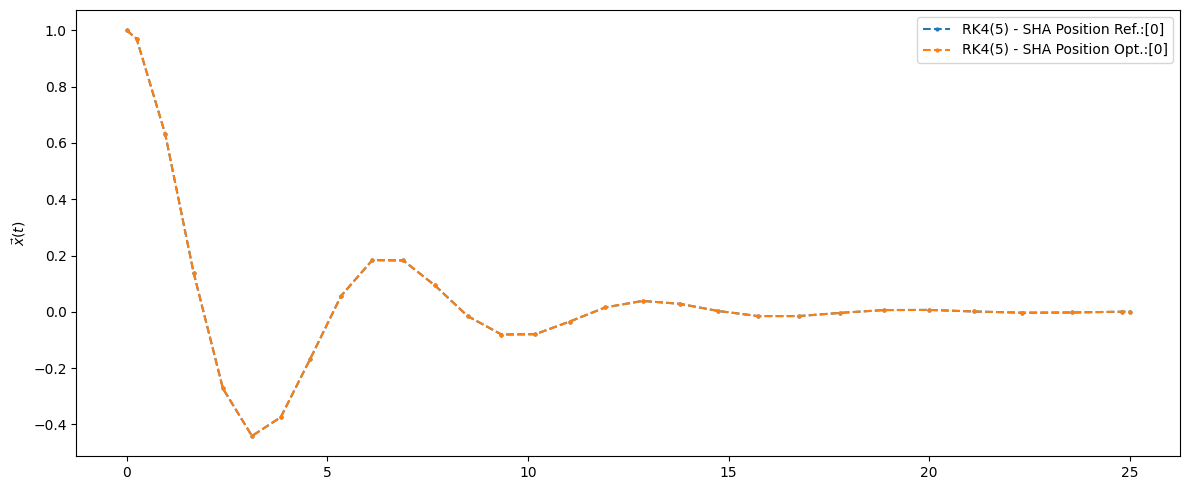

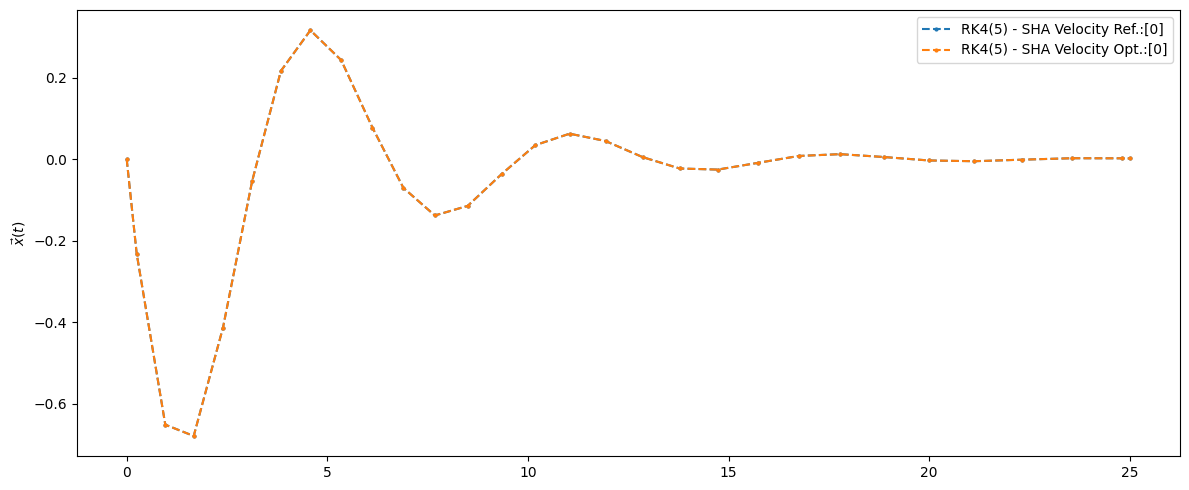

In [10]:
fig_ref_position, axes_ref_position = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Position Ref.")
fig_ref_velocity, axes_ref_velocity = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Velocity Ref.")

_, _, sha_states_optimised, sha_times_optimised, _ = current_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, initial_state, initial_time, final_time, initial_timestep, atol, rtol, best_frequency, best_damping)
_ = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_position, method_label="RK4(5) - SHA Position Opt.")
_ = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_velocity, method_label="RK4(5) - SHA Velocity Opt.")

This replicates the prior results and actually improves on them by a small margin.

Now let's add a neural network into the mix! This will be the simplest network possible aka a matrix multiplied with the input vector. While this may seem simple, you'll see that our simple harmonic oscillator can also be expressed as a matrix multiplied by the input. It has a very specific structure that arises from the fact that it was a second order equation. I've written this matrix below:

$$
\begin{bmatrix}
    x^{(1)} \\
    v^{(1)}
\end{bmatrix} = 
\mathbf{A}
\begin{bmatrix}
    x \\
    v
\end{bmatrix}
$$

where

$$
\mathbf{A} =
\begin{bmatrix}
    0 & 1 \\
    -\omega^2 & -2\zeta\omega
\end{bmatrix}
$$

Given that matrix multiplication underlies most neural networks, we can try to learn this $\mathbf{A}$-matrix and at the same time introduce some of the Neural Network machinery in PyTorch. We will revisit these later when learning more interesting/complex systems.

In [11]:
state_dataset = sha_states_ref.clone()
time_dataset  = sha_times_ref.clone()

# we define our network as a subclass of torch.nn.Module
# This allows PyTorch to appropriately track parameters
class OscillatorNet(torch.nn.Module):
    def __init__(self):
        # First we initialise the superclass, `torch.nn.Module`
        super().__init__()
        # Then we define the actual neural network
        # Most Neural Networks operate sequentially so they can be wrapped
        # inside a torch.nn.Sequential which takes each layer
        # as an argument.
        # Since we're only learning one matrix, we have
        # one layer, the `torch.nn.Linear`.
        # `torch.nn.Linear` stores a matrix and a bias which actually makes it
        # an Affine transformation rather than a purely linear transformation
        self.internal_net = torch.nn.Sequential(
            torch.nn.Linear(2, 2),
        )
    
    def forward(self, x, t):
        # Our network only depends on x, but since it could also depend on t, we have
        # included it for completeness
        # Additionally, PyTorch layers and modules expect a batched tensor
        # ie. a tensor where the first dimension is over different samples
        # Since we don't depend on batches, we check if the input is 1-dimensional
        # And add a batch dimension as needed for the internal module
        if x.dim() == 1:
            return self.internal_net(x[None])[0]
        else:
            return self.internal_net(x)

# Here we instantiate our network.
simple_oscillator_net = OscillatorNet()
# And then instantiate the weights of the network itself
def init_weights(m):
    # For each layer type, we can define how we initialise its values
    if isinstance(m, torch.nn.Linear):
        # A linear equation with a positive coefficient
        # translates to exponential growth and a negative coefficient
        # to exponential decay. In order to preserve stability we sample a matrix
        # that is biased to be negative in its entries thus ensuring
        # that our initial system is of exponential decay.
        m.weight.data.normal_(0.0, 0.1)
        if m.bias is not None:
            m.bias.data.normal_(0.0, 0.1)
simple_oscillator_net.apply(init_weights)

# `torch.autograd.Function`s track computation on all input tensors.
# For that reason, we must pass our neural network parameters to the integrator,
# which will pass it to the derivative function.
# Since our network is stateful, we don't use these parameters, but define them in 
# the function signature.
def sha_nn_fn(x, t, *nn_parameters):
    return simple_oscillator_net(x, t)

optimiser = torch.optim.Adam(simple_oscillator_net.parameters(), lr=1e-1, amsgrad=True)
# Whenever the loss plateaus, we can reduce the learning rate to improve convergence
lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser)

def sha_closure(minibatch):
    current_state = initial_state.detach().clone()
    current_time  = initial_time.detach().clone()
    optimiser.zero_grad()
    error = 0.0
    
    times = minibatch['times']
    states = minibatch['states']
    
    sorted_time_indices = torch.argsort(times)
    times, states = times[sorted_time_indices], states[sorted_time_indices]
    
    for sample_state, sample_time in zip(states, times):
        dt = torch.minimum(initial_timestep, sample_time - current_time).detach()
        current_state, current_time, _, _, _ = current_integrator.apply(sha_nn_fn, current_state, current_time, sample_time, dt, atol, rtol, *simple_oscillator_net.parameters())
        error = error + torch.linalg.norm(sample_state - current_state)/times.shape[0]
    if error.requires_grad:
        error.backward()
    return error

ideal_matrix = neuralode.dynamics.get_simple_harmonic_oscillator_matrix(frequency, damping)
ideal_bias = torch.zeros_like(initial_state)

batch_size = 16

# Now we need an optimisation `loop` where we will take steps to minimise the error. 
# We don't know how many steps are required to "train" this network, so we start with a large number
number_of_gd_steps = 1024

best_error = torch.inf
# For pytorch modules, the `state_dict` method allows us to get a copy
# of all the parameters that define the model, thus enabling us to 
# store the state as well as restore it.
best_parameters = simple_oscillator_net.state_dict()
for step in range(number_of_gd_steps):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(time_dataset.shape[0])
    for batch_idx in range(0, time_dataset.shape[0], batch_size):
        batch_dict = {
            'times': time_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
    
        step_error = optimiser.step(lambda: sha_closure(batch_dict))
        epoch_error = epoch_error + step_error.item()*batch_dict['times'].shape[0]
        # print(f"[{step+1}/{number_of_gd_steps}]/[{batch_idx}/{time_dataset.shape[0]}] Batch Error: {step_error:.6f} ", end='\r')
    epoch_error = epoch_error/time_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_parameters = simple_oscillator_net.state_dict()
    lr_on_plateau.step(epoch_error)
    learned_matrix = simple_oscillator_net.state_dict()['internal_net.0.weight']
    learned_bias = simple_oscillator_net.state_dict()['internal_net.0.bias']
    # Ideally our matrix is equivalent to our simple harmonic oscillator matrix and our bias goes to zero
    print(f"[{step+1}/{number_of_gd_steps}] Epoch Error: {epoch_error:.6f}, \nW={learned_matrix.cpu()}, \nb={learned_bias.cpu()}")
    print()
    # If the step size is too small, then we can interrupt the
    # training as it will not lead to significant improvements
    if lr_on_plateau.get_last_lr()[0] < 1e-6:
        break
    
simple_oscillator_net.load_state_dict(best_parameters)
learned_matrix = simple_oscillator_net.state_dict()['internal_net.0.weight']
learned_bias = simple_oscillator_net.state_dict()['internal_net.0.bias']

# Before we were looking at relative error, but in the case of a matrix with zeros,
# the relative error is undefined, so we look at another common metric: mean absolute error
print(f"Best matrix: {learned_matrix}, mean absolute error: {torch.mean(torch.abs(ideal_matrix - learned_matrix)).item():.6f}")
print(f"Best bias:   {learned_bias}, mean absolute error: {torch.mean(torch.abs(ideal_bias - learned_bias)).item():.6f}")

[1/1024] Epoch Error: 0.745824, 
W=tensor([[-0.2329,  0.0291],
        [ 0.1426, -0.1927]]), 
b=tensor([-0.0791,  0.0966])

[2/1024] Epoch Error: 0.508536, 
W=tensor([[-0.3856,  0.0219],
        [ 0.2257, -0.3520]]), 
b=tensor([-0.0194,  0.0870])

[3/1024] Epoch Error: 0.316934, 
W=tensor([[-0.5088, -0.0804],
        [ 0.2656, -0.4985]]), 
b=tensor([-0.0238,  0.0237])

[4/1024] Epoch Error: 0.203469, 
W=tensor([[-0.6063, -0.1644],
        [ 0.2934, -0.6131]]), 
b=tensor([-0.0164, -0.0352])

[5/1024] Epoch Error: 0.206740, 
W=tensor([[-0.6861, -0.2385],
        [ 0.3116, -0.7057]]), 
b=tensor([ 0.0045, -0.0668])

[6/1024] Epoch Error: 0.216036, 
W=tensor([[-0.7516, -0.2991],
        [ 0.3249, -0.7830]]), 
b=tensor([ 0.0185, -0.0774])

[7/1024] Epoch Error: 0.217009, 
W=tensor([[-0.8069, -0.3474],
        [ 0.3358, -0.8488]]), 
b=tensor([ 0.0228, -0.0718])

[8/1024] Epoch Error: 0.208457, 
W=tensor([[-0.8534, -0.3847],
        [ 0.3461, -0.9048]]), 
b=tensor([ 0.0169, -0.0529])

[9/1024]

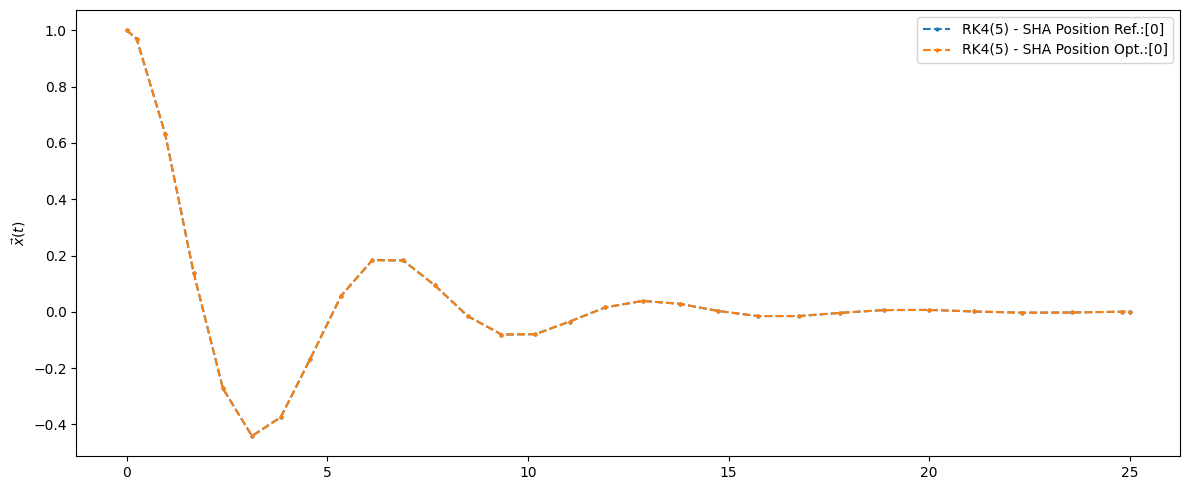

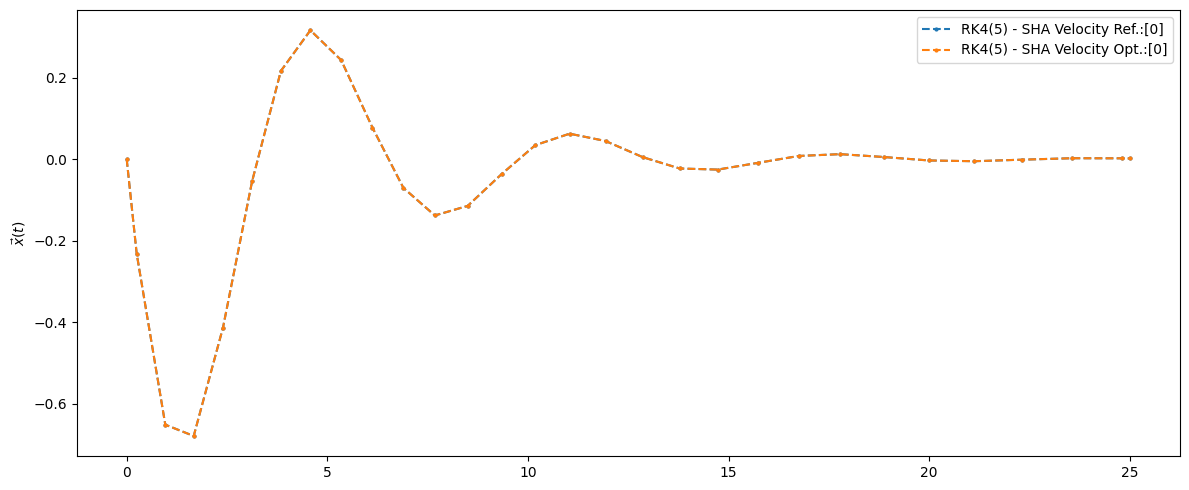

In [12]:
fig_ref_position, axes_ref_position = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Position Ref.")
fig_ref_velocity, axes_ref_velocity = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Velocity Ref.")

simple_oscillator_net.load_state_dict(best_parameters)
_, _, sha_states_optimised, sha_times_optimised, _ = current_integrator.apply(sha_nn_fn, initial_state, initial_time, final_time, initial_timestep, atol, rtol, best_frequency, best_damping)
_ = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_position, method_label="RK4(5) - SHA Position Opt.")
_ = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_velocity, method_label="RK4(5) - SHA Velocity Opt.")

And we can see that the neural network is able to effectively learn the dynamics of this system, but it would not extend to other systems with different frequency and damping as they would have a different matrix.

In the coming notebooks, we will extend our network to learn the general dynamics by passing frequency and damping as a parameter. Further, we will learn more complex system dynamics and how to manipulate these systems.